SumSquares synthetic function:

GP ERM versus GP dERM (winner)

https://www.sfu.ca/~ssurjano/sunsqu.html

In [ ]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 

In [ ]:
!pip install -q latextable


In [ ]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [ ]:
### Inputs:

obj_func = 'SumSquares'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'ERM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [ ]:
### Objective function:

if obj_func == 'SumSquares':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return  operator * (  1 * x1_training ** 2
                            + 2 * x2_training ** 2
                            )


In [ ]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [ ]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [ ]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 55
run_num_6 = 66
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 111
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [ ]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [ ]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'ERM': self.ERM
        }

        self.f = mode_dict[mode]

    def ERM(self, tau, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        gamma_h = (mean - y_global_orig) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        f = (std + self.eps) * (gamma * norm.cdf(gamma)) + eps
        df1 = f / (std + self.eps) * dsdx
        #df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df2 = (std + self.eps) * (norm.cdf(gamma) * dmdx + gamma * norm.pdf(gamma))
        df = df1 + df2
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [ ]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [ ]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t ERM exact \t ERM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 10.90216133	 1.4334487	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 34.39648697	 1.4334487	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 47.93639038	 1.4334487	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 15.32343175	 1.4334487	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 1.4334487	 1.4334487	     	     	     	     	    
1  	 [-3.78850742 -4.92168235]	 62.79870282	 1.4334487	 20.1 	 2e-08 	 2e-08 	 1.0 	 10.389
2  	 [-3.35523319 -3.71572992]	 38.87088752	 1.4334487	 22.5 	 2e-08 	 2e-08 	 1.0 	 10.975
3  	 [-3.72269849 -4.50644286]	 54.47453853	 1.4334487	 17.1 	 2e-08 	 2e-08 	 1.0 	 6.168
4  	 [-3.33869397 -3.82638572]	 40.42933282	 1.4334487	 21.0 	 2e-08 	 2e-08 	 1.0 	 9.278
5  	 [ 4.28648221 -5.11588327]	 70.71845287	 1.4334487	 25.8 	 1e-08 	 1e-08 	 1.0 	 9.951
6  	 [-2.4871086

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 47.56220442	 1.1358959	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959	 1.1358959	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 6.70185112	 1.1358959	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 12.13030006	 1.1358959	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 15.61091522	 1.1358959	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 42.1271685	 1.1358959	 25.8 	 0.0 	 0.0 	 nan 	 9.402
2  	 [-1.91223267 -4.69199145]	 47.68620134	 1.1358959	 33.2 	 -4e-08 	 -4e-08 	 1.0 	 14.83
3  	 [ 0.26350848 -4.68552508]	 43.97772718	 1.1358959	 33.3 	 2e-08 	 2e-08 	 1.0 	 9.956
4  	 [4.51702655 3.23603612]	 41.3473883	 1.1358959	 31.4 	 2e-08 	 2e-08 	 1.0 	 10.783
5  	 [-0.22797975 -4.22105544]	 35.68659279	 1.1358959	 29.0 	 2e-08 	 2e-08 	 1.0 	 9.066
6  	 [-1.4590133  -5.02322

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 9.35659664	 4.6090475	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 4.6090475	 4.6090475	     	     	     	     	    
init	 [4.02377681 4.05804123]	 49.1261771	 4.6090475	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 32.67360976	 4.6090475	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 21.83015893	 4.6090475	     	     	     	     	    
1  	 [4.46856857 4.87419313]	 67.48362237	 4.6090475	 33.8 	 2e-08 	 2e-08 	 1.0 	 9.835
2  	 [4.36967101 3.47333691]	 43.22216331	 4.6090475	 26.7 	 2e-08 	 2e-08 	 1.0 	 7.505
3  	 [3.41696394 3.81111817]	 40.72488589	 4.6090475	 27.6 	 2e-08 	 2e-08 	 1.0 	 10.434
4  	 [-3.55236556 -2.83317276]	 28.67303683	 4.6090475	 30.8 	 2e-08 	 2e-08 	 1.0 	 7.109
5  	 [4.99827459 4.82531564]	 71.55009087	 4.6090475	 20.7 	 2e-08 	 2e-08 	 1.0 	 10.561
6  	 [4.48097288 2.76126429]	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 23.33906213	 7.28991025	     	     	     	     	    
init	 [4.84028785 2.19971578]	 33.10588542	 7.28991025	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 21.00371518	 7.28991025	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 74.91598187	 7.28991025	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 7.28991025	 7.28991025	     	     	     	     	    
1  	 [4.48073302 0.22216829]	 20.1756859	 7.28991025	 29.6 	 2e-08 	 2e-08 	 1.0 	 13.455
2  	 [4.91127052 1.26534492]	 27.32277366	 7.28991025	 28.6 	 2e-08 	 2e-08 	 1.0 	 11.806
3  	 [ 5.02575942 -4.36579969]	 63.37867161	 7.28991025	 30.9 	 2e-08 	 2e-08 	 1.0 	 9.25
4  	 [ 4.65120347 -4.53421142]	 62.75184012	 7.28991025	 26.1 	 2e-08 	 2e-08 	 1.0 	 10.441
5  	 [3.84063843 0.86298268]	 16.23998181	 7.28991025	 31.0 	 2e-08 	 2e-08 	 1.0 	 13.167
6  	 [4.1844778

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.16657114  4.82975662]	 64.01341313	 9.74664422	     	     	     	     	    
init	 [-0.1652738  -2.63656754]	 13.93029218	 9.74664422	     	     	     	     	    
init	 [ 0.31870802 -2.19602703]	 9.74664422	 9.74664422	     	     	     	     	    
init	 [ 3.71333506 -4.69913443]	 57.95258603	 9.74664422	     	     	     	     	    
init	 [-4.0105192   2.73571887]	 31.05257971	 9.74664422	     	     	     	     	    
1  	 [-2.85203817  4.35990702]	 46.15170012	 9.74664422	 29.2 	 1e-08 	 2e-08 	 0.5 	 12.856
2  	 [-4.42180303  4.37684382]	 57.86586574	 9.74664422	 25.8 	 2e-08 	 2e-08 	 1.0 	 15.978
3  	 [-5.0923863   3.59001936]	 51.7088763	 9.74664422	 29.7 	 2e-08 	 2e-08 	 1.0 	 10.175
4  	 [ 2.83085068 -5.12      ]	 60.44251555	 9.74664422	 30.8 	 2e-08 	 2e-08 	 1.0 	 9.95
5  	 [-3.51955488  4.79996246]	 58.46654572	 9.74664422	 26.8 	 2e-08 	 2e-08 	 1.0 	 10.659
6  	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.5400952 -3.7509165]	 40.67102318	 0.24042003	     	     	     	     	    
init	 [-1.40610083  1.83407488]	 8.7047809	 0.24042003	     	     	     	     	    
init	 [-3.12883141 -2.54760567]	 22.77017534	 0.24042003	     	     	     	     	    
init	 [2.64618385 0.59001436]	 7.69852285	 0.24042003	     	     	     	     	    
init	 [ 0.15158188 -0.32972941]	 0.24042003	 0.24042003	     	     	     	     	    
1  	 [-3.19213902 -3.82812536]	 39.49883909	 0.24042003	 20.1 	 2e-08 	 2e-08 	 1.0 	 7.297
2  	 [-2.90760368 -3.8336975 ]	 37.84863214	 0.24042003	 29.2 	 2e-08 	 2e-08 	 1.0 	 12.073
3  	 [-1.96576812 -2.81273605]	 19.68721243	 0.24042003	 30.0 	 -3.5e-07 	 -2.1e-07 	 1.667 	 10.845
4  	 [-3.40762577 -2.01658223]	 19.74512119	 0.24042003	 32.7 	 1e-08 	 -1e-07 	 -0.1 	 13.928
5  	 [-3.01992255 -4.20241579]	 44.44052906	 0.24042003	 29.7 	 2e-08 	 2e-08 	 1.0 	 14.082


In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 35.25561299	 5.62252046	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 10.87025124	 5.62252046	     	     	     	     	    
init	 [4.8946126  0.39419771]	 24.26801621	 5.62252046	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 38.40742212	 5.62252046	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.62252046	 5.62252046	     	     	     	     	    
1  	 [ 1.10055206 -4.49555567]	 41.63125641	 5.62252046	 30.9 	 -1.52e-06 	 -2e-07 	 7.6 	 13.683
2  	 [-0.37748513 -4.55168509]	 41.5781693	 5.62252046	 28.6 	 2e-08 	 2e-08 	 1.0 	 8.969
3  	 [-0.74697223 -3.7419985 ]	 28.56307311	 5.62252046	 28.6 	 2e-08 	 2e-08 	 1.0 	 12.408
4  	 [ 0.98354299 -4.17889431]	 35.89367219	 5.62252046	 27.6 	 2e-08 	 2e-08 	 1.0 	 6.82
5  	 [-4.03620565  2.12380813]	 25.312078	 5.62252046	 29.6 	 2e-08 	 2e-08 	 1.0 	 12.1

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 60.6611937	 0.15183063	     	     	     	     	    
init	 [3.78055209 0.31596228]	 14.49223845	 0.15183063	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 57.55595953	 0.15183063	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 2.50663131	 0.15183063	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 0.15183063	 0.15183063	     	     	     	     	    
1  	 [0.29900631 1.52398619]	 4.7344726	 0.15183063	 33.0 	 0.00345478 	 0.00560822 	 0.616 	 10.844
2  	 [4.45562787 4.30061947]	 56.84327536	 0.15183063	 18.9 	 1e-08 	 2e-08 	 0.5 	 12.81
3  	 [-2.65574142 -4.6261066 ]	 49.85468708	 0.15183063	 26.2 	 2e-08 	 2e-08 	 1.0 	 10.879
4  	 [2.97463709 4.63341466]	 51.78552857	 0.15183063	 29.0 	 2e-08 	 2e-08 	 1.0 	 11.746
5  	 [2.71483065 3.19759026]	 27.81947238	 0.15183063	 41.1 	 -1.57e-06 	 -1.8e-07 	 8.722 	 14.59

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.13861318	 14.00341365	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 28.12065798	 14.00341365	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 30.04200788	 14.00341365	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 14.00341365	 14.00341365	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 23.14707552	 14.00341365	     	     	     	     	    
1  	 [-3.22005313 -2.63049548]	 24.20775512	 14.00341365	 21.2 	 2e-08 	 2e-08 	 1.0 	 6.806
2  	 [ 1.10510532e-03 -4.26451528e+00]	 36.37218233	 14.00341365	 19.6 	 2e-08 	 2e-08 	 1.0 	 5.412
3  	 [-1.22051053 -3.29095234]	 23.15038061	 14.00341365	 21.2 	 2e-08 	 2e-08 	 1.0 	 5.861
4  	 [-0.49967405 -3.86536833]	 30.13181878	 14.00341365	 23.4 	 2e-08 	 2e-08 	 1.0 	 7.082
5  	 [-1.66219158 -3.88065894]	 32.88190841	 14.00341365	 18.4 	 2e-08 	 2e-08 	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 55.8861941	 14.85502883	     	     	     	     	    
init	 [1.36855793 2.54775176]	 14.85502883	 14.85502883	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 15.88340999	 14.85502883	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 23.79413325	 14.85502883	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 47.01981043	 14.85502883	     	     	     	     	    
1  	 [ 3.36569678 -4.63978169]	 54.38306308	 14.85502883	 32.0 	 2e-08 	 2e-08 	 1.0 	 9.007
2  	 [-4.01342697 -3.28803524]	 37.7299475	 14.85502883	 36.3 	 2e-08 	 2e-08 	 1.0 	 8.123
3  	 [ 3.26692725 -4.19730704]	 45.90758636	 14.85502883	 30.9 	 2e-08 	 2e-08 	 1.0 	 11.505
4  	 [-3.22942118 -4.41309858]	 49.38003934	 14.85502883	 31.6 	 2e-08 	 2e-08 	 1.0 	 6.807
5  	 [-3.14108178 -4.64139031]	 52.95140285	 14.85502883	 27.8 	 2e-08 	 2e-08 	 1.0 	 5.558

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.1486226  -3.38872572]	 24.28625782	 12.68756485	     	     	     	     	    
init	 [-0.65475564  2.75724772]	 15.63353491	 12.68756485	     	     	     	     	    
init	 [-2.09586888 -3.59257132]	 30.20580374	 12.68756485	     	     	     	     	    
init	 [-4.88982196 -0.8169012 ]	 25.24501391	 12.68756485	     	     	     	     	    
init	 [-2.67589487 -1.6624006 ]	 12.68756485	 12.68756485	     	     	     	     	    
1  	 [-4.83893289 -0.46964077]	 23.85639644	 12.68756485	 30.2 	 2e-08 	 2e-08 	 1.0 	 11.262
2  	 [-4.40994003 -1.38515112]	 23.2848583	 12.68756485	 29.6 	 2e-08 	 2e-08 	 1.0 	 9.485
3  	 [-4.80389131 -0.83243057]	 24.463253	 12.68756485	 28.0 	 2e-08 	 2e-08 	 1.0 	 7.5
4  	 [-2.40301662 -4.39863913]	 44.47054133	 12.68756485	 33.6 	 2e-08 	 -1.9e-07 	 -0.105 	 11.72
5  	 [-1.19315392 -3.43830514]	 25.06750077	 12.68756485	 25.4 	 2e-08 	 2e-08 	 1.0 	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 24.62591779	 6.1128285	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 6.1128285	 6.1128285	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 61.48174178	 6.1128285	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 62.49130468	 6.1128285	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 49.49665109	 6.1128285	     	     	     	     	    
1  	 [ 5.07021476 -3.30174284]	 47.51008927	 6.1128285	 24.8 	 2e-08 	 2e-08 	 1.0 	 14.231
2  	 [ 3.94421959 -3.04993952]	 34.16113038	 6.1128285	 24.8 	 2e-08 	 2e-08 	 1.0 	 11.864
3  	 [3.82548532 4.2269081 ]	 50.36784215	 6.1128285	 34.0 	 1e-08 	 1e-08 	 1.0 	 12.042
4  	 [ 3.62150567 -4.27465391]	 49.6606355	 6.1128285	 30.3 	 2e-08 	 2e-08 	 1.0 	 15.645
5  	 [4.15166418 3.98393734]	 48.9798289	 6.1128285	 29.2 	 2e-08 	 2e-08 	 1.0 	 13.379
6  	 [4.22227877 4.

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 22.53262435	 12.4401513	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.51837199	 12.4401513	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 23.87458214	 12.4401513	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.16728409	 12.4401513	     	     	     	     	    
init	 [1.45012065 2.27346667]	 12.4401513	 12.4401513	     	     	     	     	    
1  	 [2.00136143 4.2859699 ]	 40.74452357	 12.4401513	 18.4 	 2e-08 	 2e-08 	 1.0 	 6.526
2  	 [2.0144624  4.74212432]	 49.03354482	 12.4401513	 18.3 	 2e-08 	 2e-08 	 1.0 	 7.337
3  	 [2.15107471 4.61691937]	 47.25901144	 12.4401513	 16.2 	 2e-08 	 2e-08 	 1.0 	 4.553
4  	 [1.26872394 3.86069423]	 31.41958026	 12.4401513	 21.2 	 2e-08 	 2e-08 	 1.0 	 6.978
5  	 [1.46616616 3.78049457]	 30.73392165	 12.4401513	 26.1 	 2e-08 	 2e-08 	 1.0 	 6.04
6  	 [3.22035283 4.23831

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 15.66915514	 6.94295185	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 65.14302308	 6.94295185	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 47.71049978	 6.94295185	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 6.94295185	 6.94295185	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 16.45574874	 6.94295185	     	     	     	     	    
1  	 [-1.82207495  3.96838356]	 34.81609328	 6.94295185	 32.8 	 2e-08 	 2e-08 	 1.0 	 11.343
2  	 [ 4.75677981 -4.35548215]	 60.56740362	 6.94295185	 35.1 	 2e-08 	 2e-08 	 1.0 	 10.872
3  	 [-3.0148545   4.93619566]	 57.82140286	 6.94295185	 31.8 	 2e-08 	 2e-08 	 1.0 	 8.852
4  	 [ 3.07234446 -4.41622269]	 48.44534617	 6.94295185	 30.9 	 2e-08 	 2e-08 	 1.0 	 9.838
5  	 [ 4.35064093 -3.65495621]	 45.64548622	 6.94295185	 35.1 	 2e-08 	 2e-08 	 1.0 	 9.775
6  	 [-

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 34.38169974	 5.47826118	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 24.84447201	 5.47826118	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 5.47826118	 5.47826118	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 11.96719024	 5.47826118	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 28.92453308	 5.47826118	     	     	     	     	    
1  	 [-4.87521872 -1.31755453]	 27.23965741	 5.47826118	 28.5 	 2e-08 	 2e-08 	 1.0 	 14.319
2  	 [-3.81345633 -2.0105857 ]	 22.62735896	 5.47826118	 21.4 	 2e-08 	 2e-08 	 1.0 	 6.562
3  	 [-4.07917126 -2.57059921]	 29.85559871	 5.47826118	 21.2 	 2e-08 	 2e-08 	 1.0 	 7.282
4  	 [-2.97553765 -2.43519349]	 20.71415891	 5.47826118	 30.9 	 2e-08 	 2e-08 	 1.0 	 9.812
5  	 [-3.73669629 -1.71969058]	 19.87757057	 5.47826118	 24.4 	 2e-08 	 2e-08 	 1.0 	 10.55
6  	 [

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 8.14123924	 8.14123924	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 43.5710395	 8.14123924	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 18.11570093	 8.14123924	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 27.44864454	 8.14123924	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 60.14651626	 8.14123924	     	     	     	     	    
1  	 [ 1.63549014 -4.57421478]	 44.52170963	 8.14123924	 29.7 	 2e-08 	 2e-08 	 1.0 	 10.051
2  	 [ 1.5788766  -3.86267437]	 32.33335787	 8.14123924	 24.0 	 2e-08 	 2e-08 	 1.0 	 9.937
3  	 [ 1.41721531 -3.71346287]	 29.58811224	 8.14123924	 22.8 	 2e-08 	 2e-08 	 1.0 	 10.874
4  	 [ 2.03227337 -4.5082449 ]	 44.77867921	 8.14123924	 23.1 	 2e-08 	 2e-08 	 1.0 	 8.132
5  	 [ 0.8109215  -3.55856791]	 25.9844048	 8.14123924	 22.0 	 2e-08 	 2e-08 	 1.0 	 7.498
6  	 [ 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 4.61725346	 3.18175623	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 49.13413497	 3.18175623	     	     	     	     	    
init	 [2.93873111 1.60085526]	 13.76161569	 3.18175623	     	     	     	     	    
init	 [1.40821398 0.77417363]	 3.18175623	 3.18175623	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 26.5181659	 3.18175623	     	     	     	     	    
1  	 [-3.64642385 -3.57471545]	 38.85358799	 3.18175623	 27.9 	 2e-08 	 2e-08 	 1.0 	 12.668
2  	 [-2.86523321 -2.60738672]	 21.8064924	 3.18175623	 31.4 	 -1.1e-07 	 -1.1e-07 	 1.0 	 11.447
3  	 [-4.03339828 -3.02173547]	 34.53007215	 3.18175623	 28.8 	 2e-08 	 2e-08 	 1.0 	 10.489
4  	 [-2.41772313 -3.72990431]	 33.66975744	 3.18175623	 30.6 	 2e-08 	 2e-08 	 1.0 	 9.729
5  	 [-2.4123832  -3.43294217]	 29.38977664	 3.18175623	 29.7 	 2e-08 	 2e-08 	 1.0 	 14.514
6  	

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 2.37732009	 2.37732009	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 36.25874706	 2.37732009	     	     	     	     	    
init	 [3.60686662 2.56139557]	 26.13098137	 2.37732009	     	     	     	     	    
init	 [1.70088108 4.99604939]	 52.81401545	 2.37732009	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 52.8539921	 2.37732009	     	     	     	     	    
1  	 [ 3.85800094 -3.23958865]	 35.87404044	 2.37732009	 25.6 	 2e-08 	 2e-08 	 1.0 	 10.655
2  	 [ 3.10819058 -3.15921625]	 29.6221433	 2.37732009	 30.6 	 2e-08 	 2e-08 	 1.0 	 12.794
3  	 [1.4667377  4.12942578]	 36.25563395	 2.37732009	 24.9 	 2e-08 	 2e-08 	 1.0 	 9.537
4  	 [0.72117263 4.82894306]	 47.15747215	 2.37732009	 24.6 	 2e-08 	 2e-08 	 1.0 	 11.153
5  	 [ 3.34513043 -3.57221802]	 36.71138074	 2.37732009	 29.1 	 2e-08 	 2e-08 	 1.0 	 10.476
6  	 [ 3.894562

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 31.29810938	 22.81445845	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 34.17704923	 22.81445845	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 39.44627428	 22.81445845	     	     	     	     	    
init	 [1.76104531 3.13952049]	 22.81445845	 22.81445845	     	     	     	     	    
init	 [4.9432772  1.38916592]	 28.29555346	 22.81445845	     	     	     	     	    
1  	 [5.06168138 1.01830551]	 27.6945106	 22.81445845	 28.5 	 2e-08 	 2e-08 	 1.0 	 15.428
2  	 [-0.79699497 -4.47211775]	 40.63487536	 22.81445845	 30.3 	 2e-08 	 2e-08 	 1.0 	 6.993
3  	 [-2.61951133 -4.60464725]	 49.26739218	 22.81445845	 28.5 	 2e-08 	 2e-08 	 1.0 	 7.737
4  	 [-1.89146012 -3.60418284]	 29.55788933	 22.81445845	 25.0 	 2e-08 	 2e-08 	 1.0 	 8.744
5  	 [-1.65790331 -5.0093755 ]	 52.93632915	 22.81445845	 24.8 	 2e-08 	 2e-08 	 1.0 	 8.517
6 

In [ ]:
### Bayesian optimisation runs (x20): 'GP ERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 33.98638836	 1.61518705	     	     	     	     	    
init	 [4.00927467 3.23417577]	 36.99406917	 1.61518705	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 30.29759868	 1.61518705	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 1.61518705	 1.61518705	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 22.27217825	 1.61518705	     	     	     	     	    
1  	 [1.13797236 4.31121945]	 38.4682073	 1.61518705	 28.5 	 2e-08 	 2e-08 	 1.0 	 10.998
2  	 [-4.62686853  2.00192655]	 29.42333221	 1.61518705	 24.3 	 2e-08 	 2e-08 	 1.0 	 9.952
3  	 [-4.76419026  1.84482783]	 29.50428822	 1.61518705	 27.3 	 2e-08 	 2e-08 	 1.0 	 7.673
4  	 [1.33501133 4.83823533]	 48.59929738	 1.61518705	 26.1 	 2e-08 	 2e-08 	 1.0 	 6.748
5  	 [3.99543235 2.36579137]	 27.15741728	 1.61518705	 31.5 	 2e-08 	 2e-08 	 1.0 	 10.116
6  	 [-4.7909854

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 10.90216133	 1.4334487	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 34.39648697	 1.4334487	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 47.93639038	 1.4334487	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 15.32343175	 1.4334487	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 1.4334487	 1.4334487	     	     	     	     	    
1  	 [-3.78850742 -4.92168235]	 62.79870282	 1.4334487	 9.6 	 2e-08 	 2e-08 	 1.0 	 7.515
2  	 [-3.35523319 -3.71572992]	 38.87088752	 1.4334487	 15.6 	 2e-08 	 2e-08 	 1.0 	 7.889
3  	 [-3.72269849 -4.50644286]	 54.47453853	 1.4334487	 10.4 	 2e-08 	 2e-08 	 1.0 	 7.924
4  	 [-3.33869397 -3.82638572]	 40.42933282	 1.4334487	 13.4 	 2e-08 	 2e-08 	 1.0 	 8.778
5  	 [ 4.28648221 -5.11588327]	 70.71845287	 1.4334487	 8.8 	 1e-08 	 1e-08 	 1.0 	 6.875
6  	 [-2.48710867 -3

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 47.56220442	 1.1358959	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 1.1358959	 1.1358959	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 6.70185112	 1.1358959	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 12.13030006	 1.1358959	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 15.61091522	 1.1358959	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 42.1271685	 1.1358959	 15.5 	 0.0 	 0.0 	 nan 	 11.878
2  	 [-1.91223267 -4.69199145]	 47.68620134	 1.1358959	 28.3 	 -4e-08 	 -4e-08 	 1.0 	 10.191
3  	 [ 0.26350848 -4.68552508]	 43.97772718	 1.1358959	 33.4 	 2e-08 	 2e-08 	 1.0 	 9.927
4  	 [4.51702655 3.23603612]	 41.3473883	 1.1358959	 23.8 	 2e-08 	 2e-08 	 1.0 	 6.597
5  	 [-0.22797975 -4.22105544]	 35.68659279	 1.1358959	 19.6 	 2e-08 	 2e-08 	 1.0 	 6.681
6  	 [-1.4590133  -5.0232

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 9.35659664	 4.6090475	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 4.6090475	 4.6090475	     	     	     	     	    
init	 [4.02377681 4.05804123]	 49.1261771	 4.6090475	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 32.67360976	 4.6090475	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 21.83015893	 4.6090475	     	     	     	     	    
1  	 [4.46856857 4.87419313]	 67.48362237	 4.6090475	 19.8 	 2e-08 	 2e-08 	 1.0 	 12.929
2  	 [4.36967101 3.47333691]	 43.22216331	 4.6090475	 16.2 	 2e-08 	 2e-08 	 1.0 	 9.853
3  	 [3.41696394 3.81111817]	 40.72488589	 4.6090475	 13.0 	 2e-08 	 2e-08 	 1.0 	 5.373
4  	 [5.12 5.12]	 78.6432	 4.6090475	 16.4 	 2e-08 	 2e-08 	 1.0 	 13.398
5  	 [4.99827459 4.82531564]	 71.55009087	 4.6090475	 15.3 	 2e-08 	 2e-08 	 1.0 	 3.026
6  	 [4.48097288 2.76126429]	 35.32827887	 4.609

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 23.33906213	 7.28991025	     	     	     	     	    
init	 [4.84028785 2.19971578]	 33.10588542	 7.28991025	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 21.00371518	 7.28991025	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 74.91598187	 7.28991025	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 7.28991025	 7.28991025	     	     	     	     	    
1  	 [4.48073302 0.22216829]	 20.1756859	 7.28991025	 16.0 	 2e-08 	 2e-08 	 1.0 	 9.295
2  	 [4.91127052 1.26534492]	 27.32277366	 7.28991025	 15.0 	 2e-08 	 2e-08 	 1.0 	 7.894
3  	 [ 5.02575942 -4.36579969]	 63.37867161	 7.28991025	 13.8 	 2e-08 	 2e-08 	 1.0 	 13.037
4  	 [ 4.65120347 -4.53421142]	 62.75184012	 7.28991025	 10.5 	 2e-08 	 2e-08 	 1.0 	 10.028
5  	 [3.84063843 0.86298268]	 16.23998181	 7.28991025	 13.8 	 2e-08 	 2e-08 	 1.0 	 11.305
6  	 [4.1844778

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.16657114  4.82975662]	 64.01341313	 9.74664422	     	     	     	     	    
init	 [-0.1652738  -2.63656754]	 13.93029218	 9.74664422	     	     	     	     	    
init	 [ 0.31870802 -2.19602703]	 9.74664422	 9.74664422	     	     	     	     	    
init	 [ 3.71333506 -4.69913443]	 57.95258603	 9.74664422	     	     	     	     	    
init	 [-4.0105192   2.73571887]	 31.05257971	 9.74664422	     	     	     	     	    
1  	 [4.19761303 2.83458919]	 33.68974687	 9.74664422	 12.7 	 1e-08 	 2e-08 	 0.5 	 10.945
2  	 [-4.42180303  4.37684382]	 57.86586574	 9.74664422	 18.8 	 2e-08 	 2e-08 	 1.0 	 14.589
3  	 [-5.0923863   3.59001936]	 51.7088763	 9.74664422	 18.6 	 2e-08 	 2e-08 	 1.0 	 19.658
4  	 [ 4.30606757 -3.60307148]	 44.50646609	 9.74664422	 20.4 	 2e-08 	 2e-08 	 1.0 	 12.987
5  	 [-3.51955488  4.79996246]	 58.46654572	 9.74664422	 18.2 	 2e-08 	 2e-08 	 1.0 	 14.506
6  	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.5400952 -3.7509165]	 40.67102318	 0.24042003	     	     	     	     	    
init	 [-1.40610083  1.83407488]	 8.7047809	 0.24042003	     	     	     	     	    
init	 [-3.12883141 -2.54760567]	 22.77017534	 0.24042003	     	     	     	     	    
init	 [2.64618385 0.59001436]	 7.69852285	 0.24042003	     	     	     	     	    
init	 [ 0.15158188 -0.32972941]	 0.24042003	 0.24042003	     	     	     	     	    
1  	 [-3.19213902 -3.82812536]	 39.49883909	 0.24042003	 15.8 	 2e-08 	 2e-08 	 1.0 	 10.782
2  	 [-2.90760368 -3.8336975 ]	 37.84863214	 0.24042003	 29.9 	 2e-08 	 2e-08 	 1.0 	 10.685
3  	 [ 4.28159102 -4.72804307]	 63.04080423	 0.24042003	 18.0 	 -3.5e-07 	 -2.1e-07 	 1.667 	 13.986
4  	 [ 4.24813914 -4.29366877]	 54.91786913	 0.24042003	 20.7 	 2e-08 	 2e-08 	 1.0 	 15.029
5  	 [ 3.55807043 -4.32044214]	 49.9923057	 0.24042003	 20.8 	 2e-08 	 2e-08 	 1.0 	 10.968
6 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 35.25561299	 5.62252046	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 10.87025124	 5.62252046	     	     	     	     	    
init	 [4.8946126  0.39419771]	 24.26801621	 5.62252046	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 38.40742212	 5.62252046	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 5.62252046	 5.62252046	     	     	     	     	    
1  	 [ 0.89655131 -5.12      ]	 53.23260424	 5.62252046	 25.8 	 -1.52e-06 	 -2e-07 	 7.6 	 7.824
2  	 [-0.37748513 -4.55168509]	 41.5781693	 5.62252046	 24.2 	 2e-08 	 2e-08 	 1.0 	 10.22
3  	 [-0.74697223 -3.7419985 ]	 28.56307311	 5.62252046	 19.5 	 2e-08 	 2e-08 	 1.0 	 12.598
4  	 [ 0.98354299 -4.17889431]	 35.89367219	 5.62252046	 19.0 	 2e-08 	 2e-08 	 1.0 	 7.647
5  	 [4.72467163 0.30930315]	 22.51385885	 5.62252046	 19.8 	 2e-08 	 2e-08 	 1.0 	 13.1

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 60.6611937	 0.15183063	     	     	     	     	    
init	 [3.78055209 0.31596228]	 14.49223845	 0.15183063	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 57.55595953	 0.15183063	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 2.50663131	 0.15183063	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 0.15183063	 0.15183063	     	     	     	     	    
1  	 [0.03169751 1.99706155]	 7.9775144	 0.15183063	 21.5 	 0.00345478 	 0.00560822 	 0.616 	 5.544
2  	 [-5.03492225  2.95509263]	 42.81558691	 0.15183063	 16.1 	 1e-08 	 2e-08 	 0.5 	 7.26
3  	 [-2.65574142 -4.6261066 ]	 49.85468708	 0.15183063	 20.6 	 2e-08 	 2e-08 	 1.0 	 5.803
4  	 [2.97463709 4.63341466]	 51.78552857	 0.15183063	 24.2 	 2e-08 	 2e-08 	 1.0 	 6.081
5  	 [ 3.25930708 -5.12      ]	 63.05188265	 0.15183063	 35.4 	 -1.57e-06 	 -0.0 	 inf 	 6.739
6  	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.13861318	 14.00341365	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 28.12065798	 14.00341365	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 30.04200788	 14.00341365	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 14.00341365	 14.00341365	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 23.14707552	 14.00341365	     	     	     	     	    
1  	 [-3.22005313 -2.63049548]	 24.20775512	 14.00341365	 7.0 	 2e-08 	 2e-08 	 1.0 	 7.215
2  	 [ 1.10510532e-03 -4.26451528e+00]	 36.37218233	 14.00341365	 9.8 	 2e-08 	 2e-08 	 1.0 	 5.848
3  	 [-1.22051053 -3.29095234]	 23.15038061	 14.00341365	 7.8 	 2e-08 	 2e-08 	 1.0 	 6.794
4  	 [-0.49967405 -3.86536833]	 30.13181878	 14.00341365	 8.0 	 2e-08 	 2e-08 	 1.0 	 12.166
5  	 [-1.66219158 -3.88065894]	 32.88190841	 14.00341365	 6.6 	 2e-08 	 2e-08 	 1.0 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 55.8861941	 14.85502883	     	     	     	     	    
init	 [1.36855793 2.54775176]	 14.85502883	 14.85502883	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 15.88340999	 14.85502883	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 23.79413325	 14.85502883	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 47.01981043	 14.85502883	     	     	     	     	    
1  	 [ 3.36569678 -4.63978169]	 54.38306308	 14.85502883	 27.8 	 2e-08 	 2e-08 	 1.0 	 8.799
2  	 [-4.01342697 -3.28803524]	 37.7299475	 14.85502883	 35.0 	 2e-08 	 2e-08 	 1.0 	 4.149
3  	 [ 3.26692725 -4.19730704]	 45.90758636	 14.85502883	 25.8 	 2e-08 	 2e-08 	 1.0 	 9.714
4  	 [-3.22942118 -4.41309858]	 49.38003934	 14.85502883	 25.8 	 2e-08 	 2e-08 	 1.0 	 12.586
5  	 [-3.14108178 -4.64139031]	 52.95140285	 14.85502883	 23.4 	 2e-08 	 2e-08 	 1.0 	 8.086

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 1.1486226  -3.38872572]	 24.28625782	 12.68756485	     	     	     	     	    
init	 [-0.65475564  2.75724772]	 15.63353491	 12.68756485	     	     	     	     	    
init	 [-2.09586888 -3.59257132]	 30.20580374	 12.68756485	     	     	     	     	    
init	 [-4.88982196 -0.8169012 ]	 25.24501391	 12.68756485	     	     	     	     	    
init	 [-2.67589487 -1.6624006 ]	 12.68756485	 12.68756485	     	     	     	     	    
1  	 [-4.83893289 -0.46964077]	 23.85639644	 12.68756485	 15.4 	 2e-08 	 2e-08 	 1.0 	 6.776
2  	 [-4.40994003 -1.38515112]	 23.2848583	 12.68756485	 25.9 	 2e-08 	 2e-08 	 1.0 	 11.888
3  	 [-4.80389131 -0.83243057]	 24.463253	 12.68756485	 19.8 	 2e-08 	 2e-08 	 1.0 	 8.128
4  	 [-1.8819659 -3.9380978]	 34.55902422	 12.68756485	 19.6 	 2e-08 	 -1.9e-07 	 -0.105 	 7.274
5  	 [-1.19315392 -3.43830514]	 25.06750077	 12.68756485	 15.6 	 2e-08 	 2e-08 	 1.0 	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 24.62591779	 6.1128285	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 6.1128285	 6.1128285	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 61.48174178	 6.1128285	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 62.49130468	 6.1128285	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 49.49665109	 6.1128285	     	     	     	     	    
1  	 [ 5.07021476 -3.30174284]	 47.51008927	 6.1128285	 10.8 	 2e-08 	 2e-08 	 1.0 	 11.38
2  	 [ 3.94421959 -3.04993952]	 34.16113038	 6.1128285	 9.1 	 2e-08 	 2e-08 	 1.0 	 13.176
3  	 [3.82548532 4.2269081 ]	 50.36784215	 6.1128285	 12.3 	 1e-08 	 1e-08 	 1.0 	 13.311
4  	 [ 2.82469321 -4.69272627]	 52.02225132	 6.1128285	 19.4 	 2e-08 	 2e-08 	 1.0 	 10.702
5  	 [4.15166418 3.98393734]	 48.9798289	 6.1128285	 18.1 	 2e-08 	 2e-08 	 1.0 	 12.175
6  	 [4.22227877 4.6

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 22.53262435	 12.4401513	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.51837199	 12.4401513	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 23.87458214	 12.4401513	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.16728409	 12.4401513	     	     	     	     	    
init	 [1.45012065 2.27346667]	 12.4401513	 12.4401513	     	     	     	     	    
1  	 [2.00136143 4.2859699 ]	 40.74452357	 12.4401513	 8.4 	 2e-08 	 2e-08 	 1.0 	 7.71
2  	 [2.0144624  4.74212432]	 49.03354482	 12.4401513	 8.4 	 2e-08 	 2e-08 	 1.0 	 6.915
3  	 [2.15107471 4.61691937]	 47.25901144	 12.4401513	 8.8 	 2e-08 	 2e-08 	 1.0 	 6.668
4  	 [2.35947349 4.69709498]	 49.69251758	 12.4401513	 10.6 	 2e-08 	 2e-08 	 1.0 	 13.603
5  	 [1.46616616 3.78049457]	 30.73392165	 12.4401513	 14.2 	 2e-08 	 2e-08 	 1.0 	 13.289
6  	 [3.22035283 4.238315

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 15.66915514	 6.94295185	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 65.14302308	 6.94295185	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 47.71049978	 6.94295185	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 6.94295185	 6.94295185	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 16.45574874	 6.94295185	     	     	     	     	    
1  	 [-1.82207495  3.96838356]	 34.81609328	 6.94295185	 19.9 	 2e-08 	 2e-08 	 1.0 	 11.576
2  	 [ 4.75677981 -4.35548215]	 60.56740362	 6.94295185	 14.4 	 2e-08 	 2e-08 	 1.0 	 15.188
3  	 [-3.0148545   4.93619566]	 57.82140286	 6.94295185	 18.1 	 2e-08 	 2e-08 	 1.0 	 14.183
4  	 [ 3.07234446 -4.41622269]	 48.44534617	 6.94295185	 19.6 	 2e-08 	 2e-08 	 1.0 	 10.779
5  	 [ 4.35064093 -3.65495621]	 45.64548622	 6.94295185	 22.2 	 2e-08 	 2e-08 	 1.0 	 9.288
6  	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 34.38169974	 5.47826118	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 24.84447201	 5.47826118	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 5.47826118	 5.47826118	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 11.96719024	 5.47826118	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 28.92453308	 5.47826118	     	     	     	     	    
1  	 [-4.87521872 -1.31755453]	 27.23965741	 5.47826118	 30.3 	 2e-08 	 2e-08 	 1.0 	 9.451
2  	 [-3.81345633 -2.0105857 ]	 22.62735896	 5.47826118	 10.8 	 2e-08 	 2e-08 	 1.0 	 8.619
3  	 [-4.07917126 -2.57059921]	 29.85559871	 5.47826118	 13.2 	 2e-08 	 2e-08 	 1.0 	 9.383
4  	 [-2.97553765 -2.43519349]	 20.71415891	 5.47826118	 16.6 	 2e-08 	 2e-08 	 1.0 	 11.075
5  	 [-3.73669629 -1.71969058]	 19.87757057	 5.47826118	 15.7 	 2e-08 	 2e-08 	 1.0 	 14.342
6  	 

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 8.14123924	 8.14123924	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 43.5710395	 8.14123924	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 18.11570093	 8.14123924	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 27.44864454	 8.14123924	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 60.14651626	 8.14123924	     	     	     	     	    
1  	 [ 1.63549014 -4.57421478]	 44.52170963	 8.14123924	 11.7 	 2e-08 	 2e-08 	 1.0 	 14.063
2  	 [ 1.5788766  -3.86267437]	 32.33335787	 8.14123924	 9.2 	 2e-08 	 2e-08 	 1.0 	 13.339
3  	 [ 1.41721531 -3.71346287]	 29.58811224	 8.14123924	 11.8 	 2e-08 	 2e-08 	 1.0 	 14.079
4  	 [ 2.03227337 -4.5082449 ]	 44.77867921	 8.14123924	 7.0 	 2e-08 	 2e-08 	 1.0 	 10.29
5  	 [ 0.8109215  -3.55856791]	 25.9844048	 8.14123924	 8.9 	 2e-08 	 2e-08 	 1.0 	 10.817
6  	 [ 1

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 4.61725346	 3.18175623	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 49.13413497	 3.18175623	     	     	     	     	    
init	 [2.93873111 1.60085526]	 13.76161569	 3.18175623	     	     	     	     	    
init	 [1.40821398 0.77417363]	 3.18175623	 3.18175623	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 26.5181659	 3.18175623	     	     	     	     	    
1  	 [-3.64642385 -3.57471545]	 38.85358799	 3.18175623	 17.4 	 2e-08 	 2e-08 	 1.0 	 7.748
2  	 [-2.86523321 -2.60738672]	 21.8064924	 3.18175623	 21.0 	 -1.1e-07 	 -1.1e-07 	 1.0 	 4.957
3  	 [-4.03339828 -3.02173547]	 34.53007215	 3.18175623	 15.6 	 2e-08 	 2e-08 	 1.0 	 10.983
4  	 [-2.41772313 -3.72990431]	 33.66975744	 3.18175623	 20.2 	 2e-08 	 2e-08 	 1.0 	 7.001
5  	 [-2.4123832  -3.43294217]	 29.38977664	 3.18175623	 22.6 	 2e-08 	 2e-08 	 1.0 	 8.25
6  	 [-3

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 2.37732009	 2.37732009	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 36.25874706	 2.37732009	     	     	     	     	    
init	 [3.60686662 2.56139557]	 26.13098137	 2.37732009	     	     	     	     	    
init	 [1.70088108 4.99604939]	 52.81401545	 2.37732009	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 52.8539921	 2.37732009	     	     	     	     	    
1  	 [-2.80984947 -4.04464278]	 40.61352451	 2.37732009	 16.0 	 2e-08 	 2e-08 	 1.0 	 11.88
2  	 [3.41801779 2.81544991]	 27.53636196	 2.37732009	 21.2 	 2e-08 	 2e-08 	 1.0 	 7.128
3  	 [-2.34551591 -4.79393049]	 51.46498392	 2.37732009	 20.1 	 2e-08 	 2e-08 	 1.0 	 7.809
4  	 [-2.58069324 -5.12      ]	 59.08877762	 2.37732009	 14.6 	 2e-08 	 2e-08 	 1.0 	 10.696
5  	 [-2.59784223 -3.28421588]	 28.32093212	 2.37732009	 19.0 	 2e-08 	 2e-08 	 1.0 	 4.224
6  	 [-3.302901

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 31.29810938	 22.81445845	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 34.17704923	 22.81445845	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 39.44627428	 22.81445845	     	     	     	     	    
init	 [1.76104531 3.13952049]	 22.81445845	 22.81445845	     	     	     	     	    
init	 [4.9432772  1.38916592]	 28.29555346	 22.81445845	     	     	     	     	    
1  	 [5.06168138 1.01830551]	 27.6945106	 22.81445845	 19.4 	 2e-08 	 2e-08 	 1.0 	 5.565
2  	 [-0.79699497 -4.47211775]	 40.63487536	 22.81445845	 21.2 	 2e-08 	 2e-08 	 1.0 	 5.17
3  	 [-2.61951133 -4.60464725]	 49.26739218	 22.81445845	 21.2 	 2e-08 	 2e-08 	 1.0 	 10.394
4  	 [-1.89146012 -3.60418284]	 29.55788933	 22.81445845	 20.6 	 2e-08 	 2e-08 	 1.0 	 4.832
5  	 [-1.65790331 -5.0093755 ]	 52.93632915	 22.81445845	 20.6 	 2e-08 	 2e-08 	 1.0 	 3.683
6  

In [ ]:
### Bayesian optimisation runs (x20): 'GP dERM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 ERM exact 	 ERM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 33.98638836	 1.61518705	     	     	     	     	    
init	 [4.00927467 3.23417577]	 36.99406917	 1.61518705	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 30.29759868	 1.61518705	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 1.61518705	 1.61518705	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 22.27217825	 1.61518705	     	     	     	     	    
1  	 [-4.74026178  2.13110881]	 31.55333127	 1.61518705	 22.4 	 2e-08 	 2e-08 	 1.0 	 6.636
2  	 [-4.62686853  2.00192655]	 29.42333221	 1.61518705	 16.2 	 2e-08 	 2e-08 	 1.0 	 9.294
3  	 [1.39762629 3.53423896]	 26.93504927	 1.61518705	 14.7 	 2e-08 	 2e-08 	 1.0 	 8.823
4  	 [4.16449834 3.00355905]	 35.38578036	 1.61518705	 12.2 	 2e-08 	 2e-08 	 1.0 	 6.862
5  	 [3.99543235 2.36579137]	 27.15741728	 1.61518705	 15.6 	 2e-08 	 2e-08 	 1.0 	 10.391
6  	 [-4.7909854

In [ ]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(0.36008321648211483, 0.36008321648211483)

In [ ]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(0.12742168273537824, 0.12742168273537824)

In [ ]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(1.5280212205010149, 1.5280212205010149)

In [ ]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(1.986491235173062, 1.986491235173062)

In [ ]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(2.276923043513145, 2.276923043513145)

In [ ]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(-1.4253677456436078, -1.4253677456436078)

In [ ]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(1.726780043546704, 1.726780043546704)

In [ ]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(-1.88498967264663, -1.88498967264663)

In [ ]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(2.6393011316822186, 2.6393011316822186)

In [ ]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.6983384495677036, 2.6983384495677036)

In [ ]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.5406223682495934, 2.5406223682495934)

In [ ]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(1.8103895949624824, 1.8103895949624824)

In [ ]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(2.5209292497796145, 2.5209292497796145)

In [ ]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(1.9377270232323485, 1.9377270232323485)

In [ ]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(1.700787747671772, 1.700787747671772)

In [ ]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(2.096942408912291, 2.096942408912291)

In [ ]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(1.157433316616564, 1.157433316616564)

In [ ]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(0.8659738420544548, 0.8659738420544548)

In [ ]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(3.073964538004432, 2.976666561132893)

In [ ]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(0.479450768952963, 0.479450768952963)

In [ ]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [ ]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [ ]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [ ]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [ ]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [ ]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [ ]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [ ]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [ ]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [ ]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [ ]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [ ]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [ ]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [ ]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [ ]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [ ]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [ ]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [ ]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [ ]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [ ]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [ ]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [ ]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [ ]:
exact_1.history


[-1.4334486961549602,
 1.99999999999882e-08,
 1.99999999999882e-08,
 9.6,
 7.514561895650163,
 -1.4334486961549602,
 2e-08,
 2e-08,
 15.6,
 7.889266551670002,
 -1.4334486961549602,
 2e-08,
 2e-08,
 10.4,
 7.92444937026179,
 -1.4334486961549602,
 2e-08,
 2e-08,
 13.4,
 8.778323106886385,
 -1.4334486961549602,
 1.499933836985437e-08,
 1.499933836985437e-08,
 8.8,
 6.875328061539579,
 -1.4334486961549602,
 2e-08,
 2e-08,
 16.4,
 5.058515335361973,
 -1.4334486961549602,
 1.9999999999719004e-08,
 1.9999999999719004e-08,
 17.2,
 14.676676146792884,
 -1.4334486961549602,
 2e-08,
 2e-08,
 15.8,
 7.698164565899668,
 -1.4334486961549602,
 2e-08,
 2e-08,
 12.3,
 7.451650278140658,
 -1.4334486961549602,
 2e-08,
 2e-08,
 15.6,
 5.094998921243601,
 -1.4334486961549602,
 2e-08,
 2e-08,
 16.2,
 10.569978495115109,
 -1.4334486961549602,
 2e-08,
 2e-08,
 22.2,
 9.269274414368951,
 -1.4334486961549602,
 2e-08,
 2e-08,
 17.3,
 5.362103076222149,
 -1.4334486961549602,
 2e-08,
 2e-08,
 14.6,
 9.949364064465

In [ ]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487, 1.4334487,
       1.4334487, 1.4334487])

In [ ]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(1.3325612336043697e-09,
 1.3325612336043697e-09,
 1.1358959044973735,
 1.1358959044973735)

In [ ]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(1.9999999723887082e-08,
 1.9999999723887082e-08,
 4.609047504113831,
 4.609047504113831)

In [ ]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(1.844653945460102e-08,
 1.844653945460102e-08,
 7.289910254474112,
 7.289910254474112)

In [ ]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(1.2798137201288698e-08,
 1.9979402164897653e-08,
 9.746644223040025,
 9.746644223040025)

In [ ]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(2e-08, 2e-08, 0.2404200335295576, 0.2404200335295576)

In [ ]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(-1.5224426873752828e-06,
 -2.003556785130177e-07,
 5.622520458601941,
 5.622520458601941)

In [ ]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(0.0034547763964004334,
 0.005608222448068659,
 0.1518306274298758,
 0.1518306274298758)

In [ ]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(1.999999942719641e-08,
 1.999999942719641e-08,
 14.00341364504739,
 14.00341364504739)

In [ ]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(2e-08, 2e-08, 14.855028828430257, 14.855028828430257)

In [ ]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(1.9926906907151458e-08,
 1.9926906907151458e-08,
 12.687564851657005,
 12.687564851657005)

In [ ]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(2e-08, 2e-08, 6.112828495563743, 6.112828495563743)

In [ ]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(1.9105993725666166e-08,
 1.9105993725666166e-08,
 12.440151302029248,
 12.440151302029248)

In [ ]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(1.999999999999998e-08,
 1.999999999999998e-08,
 6.942951853664133,
 6.942951853664133)

In [ ]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(1.9998976077568443e-08,
 1.9998976077568443e-08,
 5.478261179905657,
 5.478261179905657)

In [ ]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(1.9999999999240126e-08,
 1.9999999999240126e-08,
 8.141239237549925,
 8.141239237549925)

In [ ]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(1.9999999649563313e-08,
 1.9999999649563313e-08,
 3.1817562258207746,
 3.1817562258207746)

In [ ]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(1.9999999999999272e-08, 2e-08, 2.3773200933391867, 2.3773200933391867)

In [ ]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(1.9999988705254657e-08, 2e-08, 19.622297773795225, 21.62747588388113)

In [ ]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(1.999999993157879e-08,
 1.999999999965707e-08,
 1.615187047660523,
 1.615187047660523)

In [ ]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(20.1, 9.6)

In [ ]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(25.8, 15.5)

In [ ]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(33.8, 19.8)

In [ ]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(29.6, 16.0)

In [ ]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(29.2, 12.7)

In [ ]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(20.1, 15.8)

In [ ]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(30.9, 25.8)

In [ ]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(33.0, 21.5)

In [ ]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(21.2, 7.0)

In [ ]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(32.0, 27.8)

In [ ]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(30.2, 15.4)

In [ ]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(24.8, 10.8)

In [ ]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(18.4, 8.4)

In [ ]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(32.8, 19.9)

In [ ]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(28.5, 30.3)

In [ ]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(29.7, 11.7)

In [ ]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(27.9, 17.4)

In [ ]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(25.6, 16.0)

In [ ]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(32.7, 25.5)

In [ ]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(28.5, 22.4)

In [ ]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(13.24534936230252, 8.49069087194761)

In [ ]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(10.260700322044286, 8.373081873228037)

In [ ]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(10.328123993438124, 7.502585287429109)

In [ ]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(12.322177584873394, 10.741974187000299)

In [ ]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(10.048510213579737, 9.322268204151367)

In [ ]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(11.884995295454667, 11.635998071891729)

In [ ]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(9.094555320338708, 10.183446367569234)

In [ ]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(12.506402160211659, 7.975378683676422)

In [ ]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(6.0955634189696255, 7.668024841203997)

In [ ]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(7.157792710751582, 7.895678636162539)

In [ ]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(10.094366543694715, 8.083307172879477)

In [ ]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(11.218628168042187, 9.781390873240538)

In [ ]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(7.288820586435657, 9.797300980863998)

In [ ]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(9.69426139241341, 12.775411431562478)

In [ ]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(8.842093280554838, 10.075300672719639)

In [ ]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(8.640558859137354, 10.084655111153385)

In [ ]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(11.676494198719617, 7.626651587336657)

In [ ]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(10.356531758551686, 8.250524226281836)

In [ ]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(8.29212610062546, 5.666839760965328)

In [ ]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(8.54525686420186, 8.768861343670405)

In [ ]:
### Summarise arrays: 'GP ERM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [ ]:
### Summarise arrays: 'GP dERM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [ ]:
### Summarise arrays: 'GP ERM maximum (when compared to GP dERM, using (x20) 'exact' experiments)'

eps = 1e-04

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dERM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [ ]:
### Summarise arrays: 'GP ERM, resultant tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dERM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [ ]:
### Summarise arrays: 'GP ERM, average nfev at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(27.740000000000002, 17.464999999999996)

In [ ]:
### Summarise arrays: 'GP ERM, average Euclid at tau (when compared to GP dERM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(9.879665406717054, 9.034968509246704)

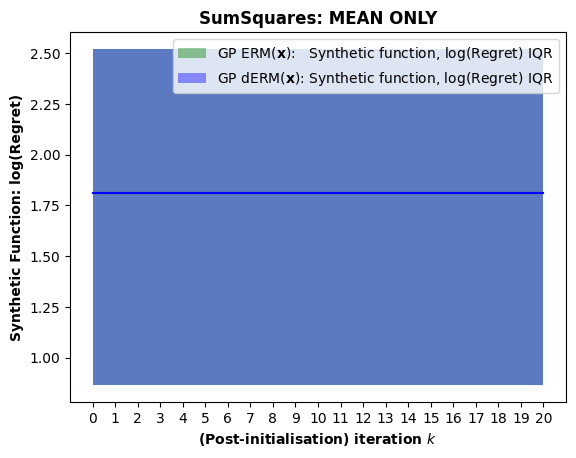

In [ ]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(median_approx, color = 'Green')
plt.plot(median_exact, color = 'Blue')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Green', alpha=0.4, label='GP ERM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Blue', alpha=0.4, label='GP dERM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


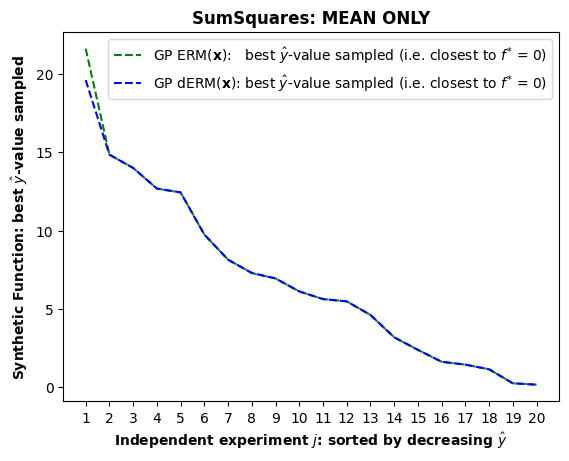

In [ ]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Green', ls='--', label='GP ERM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Blue', ls='--', label='GP dERM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


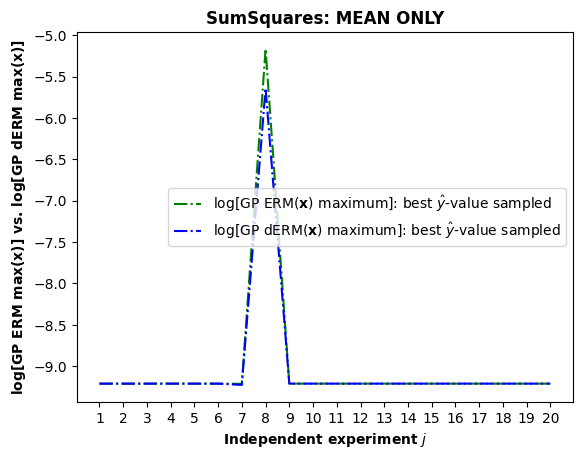

In [ ]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Green', ls='-.', label='log[GP ERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Blue', ls='-.', label='log[GP dERM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP ERM max($\mathbf{x}$)] vs. log[GP dERM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


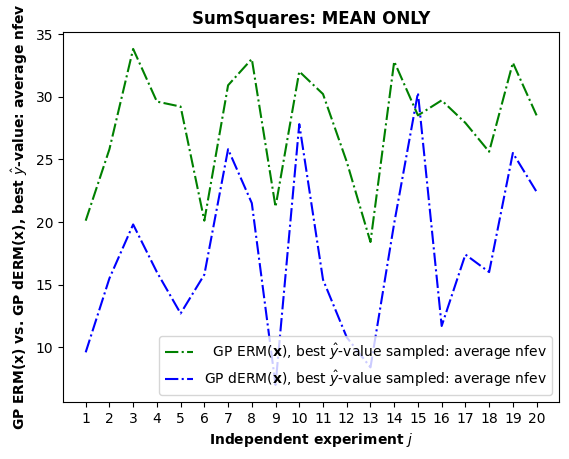

In [ ]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


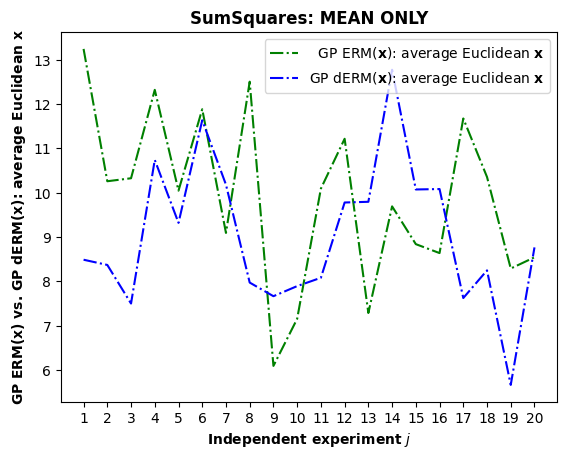

In [ ]:
### Visualise!

erm_mean = ': MEAN ONLY'
title = obj_func + erm_mean

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Green', ls='-.', label='  GP ERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Blue', ls='-.', label='GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP ERM($\mathbf{x}$) vs. GP dERM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [ ]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([-0.0644, -0.    , -0.    , -0.    , -0.    , -0.    ,  0.    ,
         0.    , -0.    , -0.    , -0.    , -0.    , -0.0644, -0.0644,
        -0.    ,  0.    ,  0.    , -0.    , -0.    , -0.0644]),
 -0.0,
 array([3.52025709, 4.00420698]))

In [ ]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([-3.215e-01, -0.000e+00, -9.700e-03, -3.100e-03, -1.000e-04,
        -6.600e-03,  0.000e+00,  0.000e+00, -3.283e-01, -7.000e-04,
        -5.300e-03, -0.000e+00, -0.000e+00, -0.000e+00, -6.700e-03,
        -1.378e-01,  0.000e+00, -9.000e-04, -4.000e-03, -0.000e+00]),
 -0.0,
 array([3.52025709, 4.00420698]))

In [ ]:
np.round(approx_4.x_best, 4)


array([[-2.5294, -0.6677],
       [-5.12  , -5.12  ],
       [-3.3111,  4.624 ],
       [ 2.4117,  4.1782],
       [-2.1135,  4.7115],
       [ 2.8797,  2.2248],
       [ 3.5203,  4.0042],
       [ 2.018 , -4.4809],
       [-4.8865,  4.1294],
       [-1.9188,  5.12  ],
       [-2.0971,  4.6109],
       [ 1.3429, -4.1896],
       [-2.5294, -0.6677],
       [-2.5294, -0.6677],
       [-2.2798,  4.7282],
       [ 2.3803,  3.6103],
       [ 3.6854, -4.4602],
       [ 4.428 , -0.4287],
       [ 1.5952, -2.5176],
       [-2.5294, -0.6677]])

In [ ]:
np.round(approx_4.x_best2, 4)


array([[-1.3778, -0.2904],
       [-5.12  , -5.12  ],
       [ 0.1881,  1.4301],
       [-0.5958,  2.5072],
       [-1.41  ,  3.7074],
       [ 2.569 ,  2.0285],
       [ 3.5203,  4.0042],
       [ 2.018 , -4.4809],
       [-3.1763,  0.6487],
       [-1.0352,  3.2078],
       [-0.3172,  2.1897],
       [ 1.3429, -4.1896],
       [-5.12  , -5.12  ],
       [-5.12  , -5.12  ],
       [-0.1795,  1.9676],
       [ 1.6219,  3.5906],
       [ 3.6854, -4.4602],
       [ 4.3745, -0.7374],
       [ 1.288 , -2.2238],
       [-5.12  , -5.12  ]])

In [ ]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


8.869874781503357

In [ ]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

10.887695168219587